In [1]:
import arviz as az
import pandas as pd
import numpy as np
import pystan
import fetching
import functions
import itertools

from matplotlib import pyplot as plt
plt.style.use('fr_sparse')

This notebook demonstrates a statistical model that uses publicly available data about local authorities to investigate  Labour's performance in the 2018 local elections, following on from the September Campaign Lab event. There are several reasons why this could be a useul exercise - knowing which factors are most relevant can help to predict where Labour is more or less likely to gain council seats in future. Working in the other direction it is also interesting to look for wards where the Labour vote was higher or lower than would be expected given the information available to the model - this can unearth otherwise hidden dynamics or potentially highlight cases where local campaigning has been particularly effective.

To try and achieve this we use a Bayesian robust-errors regression model where the response variable for each local authority is the change in the Labour party's share of the aggregate two-party (i.e. Labour and Conservative) vote, compared to the previous local elections. 

In other words, the model's likelihood function has the following form:

$$
\mathbf{y} \sim student{\text -}t(\nu, X\mathbf{b}, \sigma)
$$

In order to take take into account that the effects of interest might change across the country, the vector of slopes $\mathbf{b}$ is allowed to vary by region, with between-region variation controlled by hierarchical priors. For each predictor $p$ and region $r$, the corresponding regression parameter $b_{rp}$ has the prior distribution

$$
b_{pr} \sim Normal(\mu_{p}, \tau_{p})
$$

The predictor means $\mathbf{\mu}$ have standard normal prior distributions, while the predictor standard deviations  $\tau$ and response standard deviation $\sigma$ have standard half-normal priors. The student-t degrees of freedom parameter $\nu$ has a gamma prior.

Here is some further reading about Stan, MCMC and multi-level modelling:
 - [A really nice visualisation of Hamiltonian Monte Carlo](https://chi-feng.github.io/mcmc-demo/app.html#NaiveNUTS,banana)
 - [A paper about the history of Markov Chain Monte Carlo](https://arxiv.org/abs/1706.01520)
 - [A conceptual introduction to Hamiltonian Monte Carlo (with pictures!)](https://arxiv.org/abs/1701.02434)
 - [A very nice blog post about Hamiltonian Monte Carlo](http://elevanth.org/blog/2017/11/28/build-a-better-markov-chain/)
 - [What are multilevel models and why should I use them?](http://www.bristol.ac.uk/cmm/learning/multilevel-models/what-why.html)
 - [A case study applying multi-level modelling of baseball (and explaining why multi-level models are useful)](http://mc-stan.org/users/documentation/case-studies/pool-binary-trials.html)


## Data fetching

The data that needs to be fetched is as follows:

- Vote shares by local authority. Data for the 2018 local elections comes from the website [democracy club](democracyclub.org.uk), while data for previous elections comes from [www.andrewteale.me.uk](www.andrewteale.me.uk).
- Average annual gross earnings from [the Office of National Statistics website](https://download.beta.ons.gov.uk/downloads/datasets/ashe-table-8-earnings/editions/time-series/versions/1.csv)
- Local authority housing waiting lists from 2010 to 2017 [gov.co.uk](https://www.gov.uk/government/uploads/system/uploads/attachment_data/file/674350/LT_600.xlsx)
- Vote shares in the 2016 EU referendum by local authority from the [electoral commission](https://www.electoralcommission.org.uk/__data/assets/file/0014/212135/EU-referendum-result-data.csv)
- a map of local authorities to regions from [geoportal.com](http://geoportal1-ons.opendata.arcgis.com/datasets/c457af6314f24b20bb5de8fe41e05898_0.csv)

Functions for fetching this data live in the file `fetching.py` - each one returns a [pandas](https://pandas.pydata.org/) object (a dataframe or a series) indexed by local authority. The cell below calls these functions, joins their output together into a single pandas dataframe and displays the first few rows.

In [2]:
%%capture

vote_shares = fetching.fetch_vote_shares()
vote_share_change = functions.get_vote_share_change(vote_shares)
earnings = fetching.fetch_earnings(authorities=vote_share_change.index)
authority_to_region = fetching.fetch_authority_to_region()
waiting_list = fetching.fetch_housing_waiting_lists()
leave_vote_share = fetching.fetch_leave_vote_share()
population = fetching.fetch_population_by_authority()

authorities_all = (
    vote_share_change
    .join(waiting_list.add_prefix('waiting_list_'), how='left')
    .join(population, how='left')
    .join(earnings.add_prefix('median_income_'), how='left')
    .join(authority_to_region)
    .join(leave_vote_share)
    .assign(region_stan=lambda df: functions.stanify_series(df['region']),
            dummy_predictor=1.0)
)
display(authorities_all.head())

# Missing data

There are some cases where not all the information is available for a local authority. The easiest way of dealing with this issue is to disregard all the cases where the information is incomplete. The downside of using this method is that a lot of potentially useful information is ignored - other options along these lines feature later in the notebook.

In [166]:
predictors = ['dummy_predictor', 'median_income_2017', 'leave_vote_share']
predictors_wait = ['dummy_predictor', 'median_income_2017', 'leave_vote_share', 'waiting_list_ratio']

authorities = authorities_all.dropna(subset=predictors_wait + ['lab_2p_change'], how='any').copy()

## Model

The next cell uses [pystan](https://pystan.readthedocs.io/en/latest/) to compile a [Stan](http://mc-stan.org/) model and print its code.

This is a good point to discuss some points about the implementation of the model.

In order to promote more efficient sampling, The parameters `a` and `b` have non-centered parameterisations - they are defined in the `transformed parameters` block based on the values of variables `z_a` and `z_b` with standard normal distributions.

The model centres and rescales the predictors in its `transformed data` block - this is to prevent numerical issues and make it easier to compare the predictors' associated regression parameters.

The generated quantities `y_tilde` are samples from the posterior predictive distribution and can be thought of as representing the model's opinion about the likely value of each local authority's change in labour vote share. The `log_lik` generated quantities represent how surprising the model finds each actually-observed response.

In [179]:
model = pystan.StanModel(file="../stan/model.stan")
print(model.model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0eab497ca4fda5538a2628578c69b117 NOW.


/* 
 * A linear regression model of vote share changes with intercepts and slopes
 * varying by region. The model generates predicted shares and a log likelihood
 * for each observation
 */

data {
  int<lower=1> N;
  int<lower=1> P;  // number of predictors
  int<lower=1> R;  // number of regions
  matrix[N, P] x;
  int<lower=1,upper=R> region[N];
  vector[N] y;     // change in vote share
}
transformed data {
  matrix[N, P] x_rescaled;
  for (p in 1:P){
    x_rescaled[,p] =
      sd(x[, p]) > 0 ?
      (x[,p] - mean(x[,p])) / sd(x[,p]) :
      x[, p];
  }
}
parameters {
  matrix[P, R] z_b; 
  vector[P] mu;
  real<lower=0> sigma;
  real nu;
  vector<lower=0>[P] tau;
}
transformed parameters {
  matrix[P, R] b;                      // slopes - one for each predictor/region
  for (p in 1:P)
    b[p] = mu[p] + z_b[p] * tau[p];
}
model {
  for (n in 1:N){
    y[n] ~ student_t(nu, x_rescaled[n] * b[, region[n]], sigma);
  }
  to_vector(z_b) ~ normal(0, 1);
  mu ~ normal(0, 1);
  tau ~ norm

## Data exploration

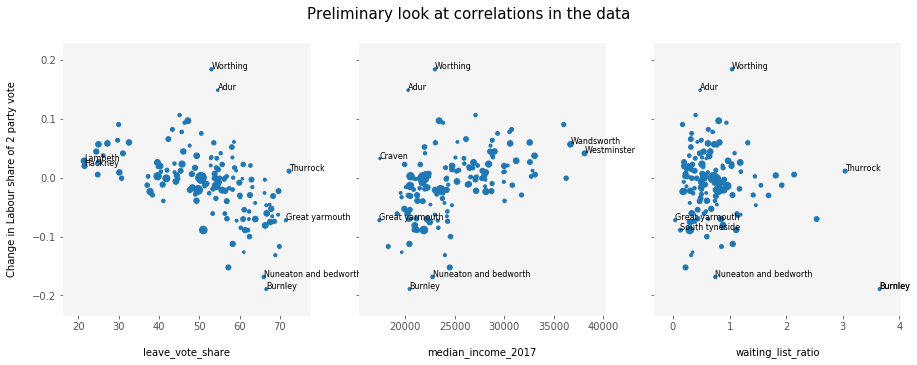

In [152]:
def extreme_scatter(df, x_col, y_col, scale=5, ax=plt, x_extremes=2, y_extremes=2):
    """Scatter plot with labelled extremes"""
    extremes = (list(df.sort_values(y_col)[y_col].dropna().iloc[np.r_[0:y_extremes, -y_extremes:0]].index)
                + list(df.sort_values(x_col)[x_col].dropna().iloc[np.r_[0:x_extremes, -x_extremes:0]].index))
    ax.scatter(df[x_col], df[y_col], s=scale)
    for i, r in df.loc[extremes].iterrows():
        t = ax.text(df.loc[i, x_col], df.loc[i, y_col], i.capitalize(), fontsize=8)

population_scale = authorities['population']/10000

f, axes = plt.subplots(1, 3, figsize=[15, 5], sharey=True)  
f.suptitle("Preliminary look at correlations in the data", fontsize=15)
for ax, x_col in zip(axes, ['leave_vote_share', 'median_income_2017', 'waiting_list_ratio']):
    s = extreme_scatter(authorities, x_col=x_col, y_col='lab_2p_change', scale=population_scale, ax=ax)
    xlabel = ax.set_xlabel(x_col)

ylabel = axes[0].set_ylabel("Change in Labour share of 2 party vote")

There seem to be pretty clear relationships between our response variable and the first two predictors, but not the waiting list ratio. Adur and Worthing seem quite different from the other local authorities. The model will help us to determine whether the 

## Model fitting and verification

In this section we fit two versions of our model and runs some standard tests to see how well they fit the data.

In [185]:
model_input, model_input_wait = ({
    'N': len(authorities),
    'P': len(pred),
    'R': authorities['region'].nunique(),
    'x': authorities[pred].astype(float),
    'region': authorities['region_stan'],
    'y': authorities['lab_2p_change']
} for pred in [predictors, predictors_wait])

fit = model.sampling(iter=600, chains=3, data=model_input, control={'adapt_delta':0.95})
fit_wait = model.sampling(iter=600, chains=3, data=model_input_wait, control={'adapt_delta':0.98})

samples, samples_wait = fit.to_dataframe(), fit_wait.to_dataframe()

for f in [fit, fit_wait]:
    summary_pars = ['lp__'] + [p for p in f.model_pars if p not in ['log_lik', 'y_tilde', 'b', 'z_b']]
    print(f.stansummary(pars=summary_pars))

display(samples.head())

Inference for Stan model: anon_model_0eab497ca4fda5538a2628578c69b117.
3 chains, each with iter=600; warmup=300; thin=1; 
post-warmup draws per chain=300, total post-warmup draws=900.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
lp__   286.51    0.36   5.43 275.43 283.01 286.68 290.06 296.94    233   1.01
mu[1] -4.1e-3  4.2e-4 9.1e-3  -0.02-9.1e-3-3.6e-3 1.4e-3   0.01    470    1.0
mu[2]    0.01  4.9e-4   0.01-6.0e-3 6.6e-3   0.01   0.02   0.04    547    1.0
mu[3]   -0.03  4.1e-4 9.1e-3  -0.05  -0.03  -0.03  -0.02  -0.01    477    1.0
sigma    0.04  2.1e-4 4.1e-3   0.03   0.03   0.04   0.04   0.05    394   1.01
nu       9.18     0.6   6.82   2.74   4.64   6.74  11.48   30.2    129   1.03
tau[1]   0.02  5.3e-4 9.6e-3 1.1e-3 8.3e-3   0.01   0.02   0.04    336    1.0
tau[2]   0.02  8.2e-4   0.02 8.7e-4 7.2e-3   0.02   0.03   0.06    339   1.01
tau[3]   0.01  5.3e-4 9.9e-3 8.6e-4 6.1e-3   0.01   0.02   0.04    352    1.0

Samples were drawn using NUTS at M

,chain,chain_idx,warmup,divergent__,energy__,treedepth__,accept_stat__,stepsize__,n_leapfrog__,"z_b[1,1]",...,log_lik[129],log_lik[130],log_lik[131],log_lik[132],log_lik[133],log_lik[134],log_lik[135],log_lik[136],log_lik[137],lp__
0,1,1,0,0,-264.238913,6,0.976623,0.086003,63,1.158650,...,2.127018,0.701374,2.236433,2.256757,1.023570,2.267311,2.331747,-2.407141,2.015905,285.511708
1,1,2,0,0,-265.524167,6,0.894238,0.086003,63,1.209642,...,1.804726,1.166278,2.460922,2.483852,0.472574,2.207389,2.484082,-3.930524,1.530542,283.790007
2,1,3,0,0,-268.736948,6,0.988356,0.086003,63,-0.478829,...,2.102901,-0.337604,2.210262,1.860892,1.868461,2.197233,2.336427,-3.772383,1.711903,282.324097
3,1,4,0,0,-250.252911,6,0.956254,0.086003,63,0.929732,...,1.822642,0.979421,2.334757,2.347206,0.967893,2.379682,2.379773,-3.909519,2.195394,278.375279
4,1,5,0,0,-265.369010,6,0.990490,0.086003,63,0.688207,...,2.321724,0.035712,2.200872,2.038648,1.695088,2.038453,2.395634,-4.119727,1.366021,283.424215


The next cell translates both fits into `InferenceData` objects that work well with functions from the [Arviz](https://arviz-devs.github.io/arviz/index.html) package and compares them using approximate leave-one-observation-out cross-validation.

In [186]:
region_stan_to_region = authorities.groupby('region_stan')['region'].first()

regions = list(region_stan_to_region.values)
inference_data, inference_data_wait = (
    az.from_pystan(fit=f,
                   posterior_predictive='y_tilde',
                   observed_data=['y'],
                   log_likelihood='log_lik',
                   coords={'predictors': pred, 'regions': regions},
                   dims={'mu': ['predictors'], 'tau': ['predictors'], 'b': ['predictors', 'regions']})
    for f, pred in zip([fit, fit_wait], [predictors, predictors_wait])
)
az.compare({'waiting_list_excluded': inference_data, 'waiting_list_included': inference_data_wait}, ic='loo')

/Users/teddy/.pyenv/versions/3.6.0/lib/python3.6/site-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/Users/teddy/.pyenv/versions/3.6.0/lib/python3.6/site-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))
/Users/teddy/.pyenv/versions/3.6.0/lib/python3.6/site-packages/arviz/stats/stats.py:372: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for
        one or more samples. You should consider using a more robust model, this is because
        importance sampling is less likely to work well if th

,loo,ploo,dloo,weight,se,dse,warning
waiting_list_excluded,-452.865,16.8262,0,0.614032,22.7186,0,0
waiting_list_included,-452.316,21.7237,0.549267,0.385968,22.8421,3.61629,1


This comparison is problematic as the model with waiting lists included is quite sensitive to single observations, making approximate leave-one-out cross-validation less reliable. Since there doesn't seem to be a very big difference between the two models' scores, from now on we proceed with the simpler model without the waiting list predictor.

The next cell compares the observed data with the model's predictions

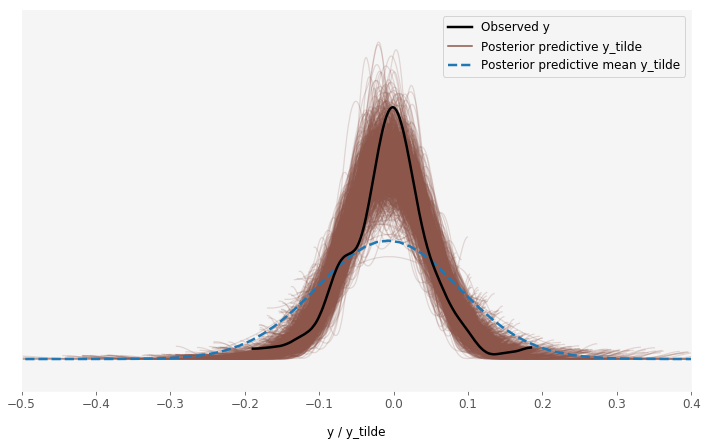

In [189]:
az.plot_ppc(inference_data, data_pairs={'y': 'y_tilde'}, figsize=[12, 7], textsize=12)
ax = plt.gca()
lims = ax.set_xlim(-0.5, 0.4)

The predictions match the observed data fairly well, but the observed data has slightly greater density than the predictions in the centre and less density in the tails. In other words, the model tended to predict a bit more change in Labour's share of the two party vote than actually happened. The model may need more information in order to fully capture the process behind the data.

## Interpreting the results

Now we can take a qualified look at what the model says about the different local authorities.

First we plot the regression parameters to get an idea of what the model thinks the effects of the different predictors was in the different regions.


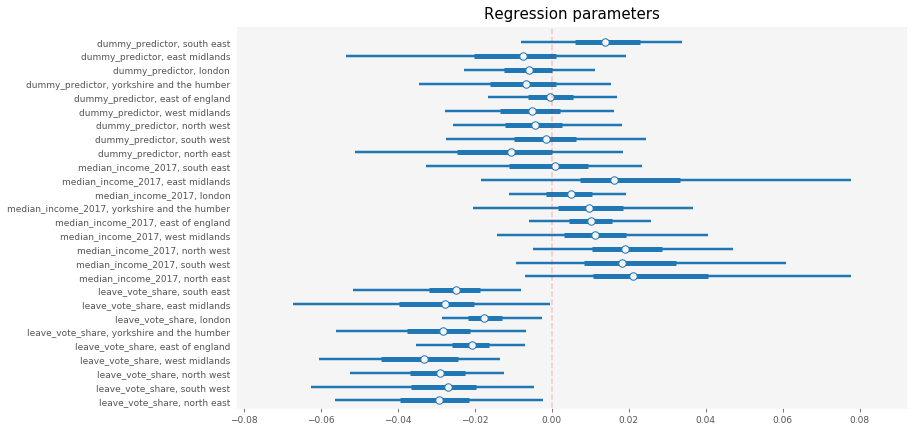

In [200]:
az.plot_forest(
    [inference_data], var_names=['b'], combined=True, textsize=9, r_hat=False, n_eff=False, figsize=[12, 7]
)
ax = plt.gca()
labels = ax.set_yticklabels([l.get_text()[3:-1]for l in ax.get_yticklabels()])
line = ax.axvline(0, linestyle='--', color='r', alpha=0.2)
title = ax.set_title("Regression parameters", fontsize=15, y=0.95)

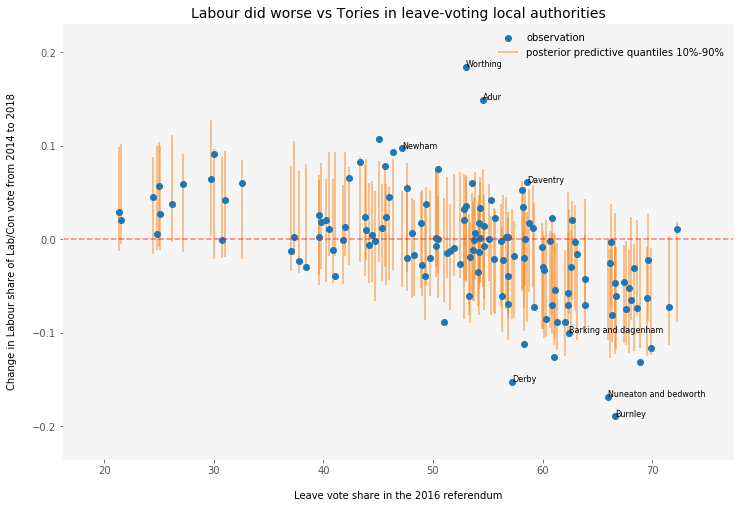

In [191]:
def la_scatter(df, x_col, ax, n_extremes=8, s=None):

    ax.scatter(df[x_col], df['lab_2p_change'], label='observation', s=s)
    ax.vlines(df[x_col], df['ppc_lower'], df['ppc_upper'], 
              color='tab:orange', zorder=0, alpha=0.6, label='posterior predictive quantiles 10%-90%')
    ax.axhline(0, color='r', linestyle='--', alpha=0.5)
    extremes = list(df.sort_values('log_likelihood_mean')[:n_extremes].index)
    for i, r in df.loc[extremes].iterrows():
        if all(np.isfinite(df.loc[i, [x_col, 'lab_2p_change']].astype(float))):
            ax.text(df.loc[i, x_col], df.loc[i, 'lab_2p_change'], i.capitalize(), fontsize=8)

ppc_samples = samples[[c for c in samples.columns if 'y_tilde' in c]].copy()
log_lik_samples = samples[[c for c in samples.columns if 'log_lik' in c]].copy()
authorities['log_likelihood_mean'] = log_lik_samples.mean().values
authorities['ppc_lower'] = ppc_samples.quantile(0.1).values
authorities['ppc_mean'] = ppc_samples.mean().values
authorities['ppc_upper'] = ppc_samples.quantile(0.9).values

f, ax = plt.subplots(figsize=[12, 8])
plot = la_scatter(authorities, 'leave_vote_share', ax)
legend = ax.legend(frameon=False)
xlabel = ax.set_xlabel('Leave vote share in the 2016 referendum')
ylabel = ax.set_ylabel('Change in Labour share of Lab/Con vote from 2014 to 2018')
title = ax.set_title('Labour did worse vs Tories in leave-voting local authorities', fontsize=14, y=0.95)

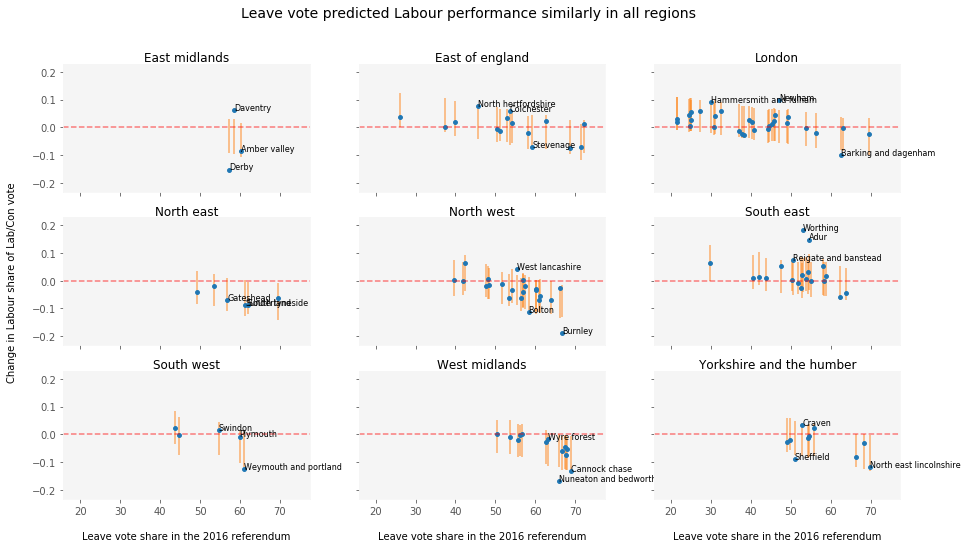

In [192]:
f, axes = plt.subplots(3, 3, figsize=[15, 8], sharex=True, sharey=True)
axes = axes.ravel()

f.suptitle("Leave vote predicted Labour performance similarly in all regions", fontsize=14)
for ax, (region, df) in zip(axes, output.groupby('region')):
    la_scatter(df, 'leave_vote_share', ax, n_extremes=3, s=15)
    if ax == axes[3]:
        ax.set_ylabel('Change in Labour share of Lab/Con vote')
    if ax in axes[6:]:
        ax.set_xlabel('Leave vote share in the 2016 referendum')
    ax.set_title(region.capitalize(), y=0.8)

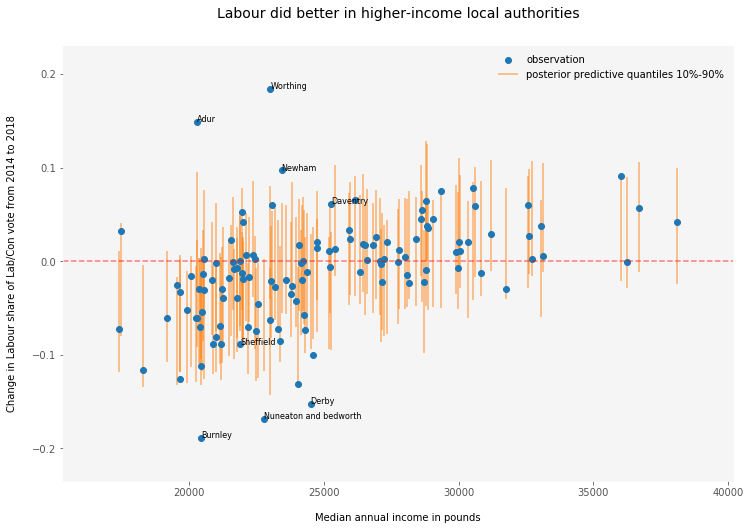

In [193]:
f, ax = plt.subplots(figsize=[12, 8])
plot = la_scatter(output, 'median_income_2017', ax)
legend = ax.legend(frameon=False)
xlabel = ax.set_xlabel('Median annual income in pounds')
ylabel = ax.set_ylabel('Change in Labour share of Lab/Con vote from 2014 to 2018')
title = ax.set_title("Labour did better in higher-income local authorities", fontsize=14)

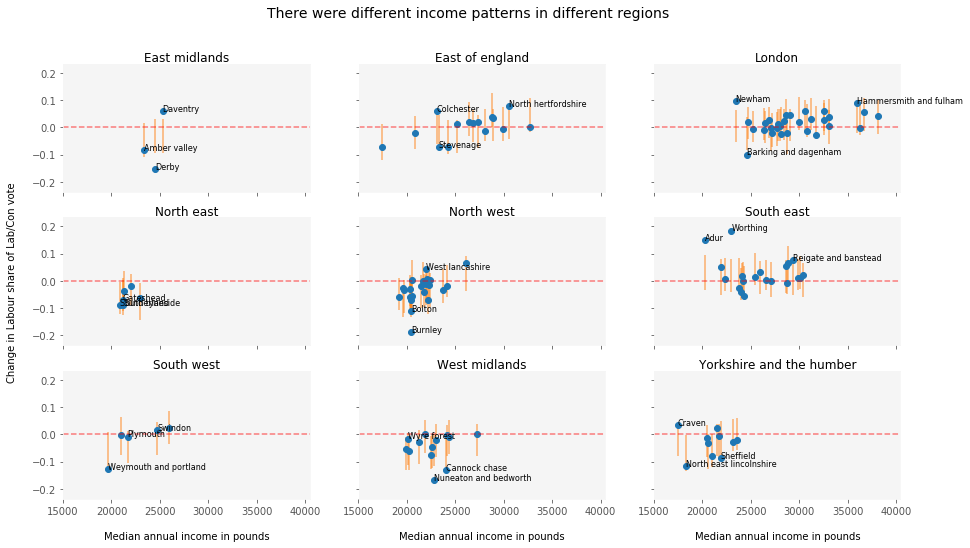

In [194]:
# f, axes = plt.subplots(3, 3, figsize=[12, 8], sharex=True, sharey=True)
# f.suptitle("There were different income patterns in different regions!", fontsize=14)

# axes = axes.ravel()
# x_col = 'median_income_2017'

f, axes = plt.subplots(3, 3, figsize=[15, 8], sharex=True, sharey=True)
axes = axes.ravel()

f.suptitle("There were different income patterns in different regions", fontsize=14)
for ax, (region, df) in zip(axes, output.groupby('region')):
    la_scatter(df, 'median_income_2017', ax, n_extremes=3)
    if ax == axes[3]:
        ax.set_ylabel('Change in Labour share of Lab/Con vote')
    if ax in axes[6:]:
        ax.set_xlabel('Median annual income in pounds')
    ax.set_title(region.capitalize(), y=0.8)

## Conclusions

From the 

- The leave share tended to predict changes in Labour's share of the two party vote pretty well, with a similar effect in all regions and a 

- There is a slightly smaller income effect, which varies more between regions than the leave effect.

- Labour's performance was better in local authorities in the South East, compared with the other regions.

- There were some anomalous local authorities - Adur and Worthing had much better Labour performance than the model expected, while Burnley, Nuneaton and Bedworth and Derby had much worse than expected performance. These local authorities might be interesting to investigate further to see if there is a problem with the data or else if there are some interesting non-modelled facts about these local authorities.


## Ways to improve the model

The model did a fairly good job of capturing the patterns in the vote-share data, but there are several natural ways in which it could be developed.

#### More predictors
There is a lot more data avaiailable about different local authorities - the model could certainly be improved by taking some of this data into account.

#### Imputing missing predictors
There are several local authorities where change in vote share is available but some predictors are missing. The model could probably be improved by imputing the missing values rather than leaving these local authorities out of the model.

#### Take into account other parties
Modelling changes in Labour's two-party vote share is a convenient way to create a low-dimensional problem, but it would be interesting to take other parties into account. In this way we could hope to capture more regional trends - for example, the Liberal Democrat party tends to run very differnt campaigns in the South West of England compared to London, and it is likely that these patterns are relevant to Labour's performance.

#### Dynamic model
It would also be interesting to directly model changes in vote share in a local authority from one election to the next.